In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.stats as sps
from scipy.special import erf as errorfunc

def crps_func(mu, sg, y):
    ep = np.abs(y - mu)
    crps = sg * (
        (ep / sg) * errorfunc(ep / (np.sqrt(2) * sg))
        + np.sqrt(2 / np.pi) * np.exp(-(ep**2) / (2 * sg**2))
        - 1 / np.sqrt(np.pi)
    )
    return crps

#Load the dataset
predict_test = pd.read_hdf('./data/testrun_300s_20240815_outputs.h5', key = 'plasmasheet_test')
geotail_test = pd.read_hdf('./data/testrun_300s_20240815_outputs.h5', key = 'geotail_test')
predict_test['temp'] /= 1000 #Convert to keV
geotail_test['temp'] /= 1000 #Convert to keV

/tmp/ipykernel_1947/4265625282.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<Axes: >

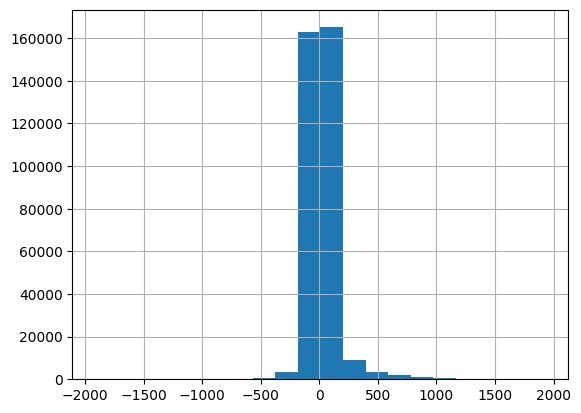

In [3]:
geotail_test['Vx'].hist(bins=20)

In [ ]:
#Make model-target joint distributions for PRIME and Geotail
# Plot joint distributions for MHD, analytical models, and PRIME-SH
nbins = 50
keys = [
    "N",
    "temp",
    "Vx",
    "Vy",
    "Vz",
    "Bx",
    "By",
    "Bz",
]  # Keys for the data parameters to be compared
bounds = [
    [0,2],
    [0,15],
    [-250,250],
    [-250,250],
    [-250,250],
    [-30,30],
    [-20,20],
    [-5, 30],
]
titles = [
    "$n_{i}$",
    "$T_{i}$",
    r"$V_{X}$ GSE",
    r"$V_{Y}$ GSE",
    r"$V_{Z}$ GSE",
    r"$B_{X}$ GSM",
    r"$B_{Y}$ GSM",
    r"$B_{Z}$ GSM",
]
units = [r"$cm^{-3}$", "keV", "km/s", "km/s", "km/s", "nT", "nT", "nT"]
nrows = 2
ncols = 4
textsize = 14
fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(22, 10)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

for idx, key in enumerate(keys):
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im = ax[idx // ncols, idx % ncols].hexbin(
        geotail_test[key],
        predict_test[key],
        gridsize=nbins,
        norm=LogNorm(1e0, 1e5),
        extent=(bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]),
        cmap='inferno',
    )
    ax[idx // ncols, idx % ncols].tick_params(
        axis="both", which="major", labelsize=textsize
    )
    ax[idx // ncols, idx % ncols].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[idx // ncols, idx % ncols].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[idx // ncols, idx % ncols].set_aspect("equal")
    ax[idx // ncols, idx % ncols].set_xlabel(
        "Target (" + units[idx] + ")", fontsize=textsize
    )
    ax[idx // ncols, idx % ncols].set_ylabel(
        "PRIME-PS (" + units[idx] + ")", fontsize=textsize
    )
    ax[idx // ncols, idx % ncols].set_title(titles[idx], fontsize=textsize)
    ax[idx // ncols, idx % ncols].autoscale(enable=False)
    ax[idx // ncols, idx % ncols].plot(
        np.linspace(-1800, 1800, 1000),
        np.linspace(-1800, 1800, 1000),
        color="k",
        linestyle="--",
    )
    model_crps = np.mean(
        crps_func(
            predict_test[key].to_numpy(),
            predict_test[key + "_sig"].to_numpy(),
            geotail_test[key].to_numpy(),
        )
    )
    model_mae = np.mean(np.abs(predict_test[key] - geotail_test[key]))
    model_r, model_p = sps.pearsonr(predict_test[key], geotail_test[key])
    ax[idx // ncols, idx % ncols].text(
        0.01,
        0.99,
        " CRPS: "
        + str(model_crps)[0:5]
        + " "
        + units[idx]
        + "\n MAE: "
        + str(model_mae)[0:5]
        + " "
        + units[idx]
        + "\n r: "
        + str(model_r)[0:5],
        ha="left",
        va="top",
        transform=ax[idx // ncols, idx % ncols].transAxes,
        color="k",
        fontsize=textsize,
    )
  
# Put colorbar for im1 on the right top third of the rows
cbar_ax = fig.add_axes([0.91, 0.1, 0.01, 0.8])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Counts", fontsize=textsize)
cbar.ax.tick_params(labelsize=textsize)
# plt.savefig('./plots/primeps_geotail.png', bbox_inches='tight', dpi=150)

In [5]:
loc_df = geotail_test.loc[:,['Rx_int','Ry_int','Rz_int','tilt_int']]
loc_df

,Rx_int,Ry_int,Rz_int,tilt_int
0,-8.470000,14.284286,-3.164286,-11.567143
1,-8.474286,14.285306,-3.162449,-11.564082
2,-8.508571,14.293469,-3.147755,-11.539592
3,-8.512857,14.294490,-3.145918,-11.536531
4,-8.517143,14.295510,-3.144082,-11.533469
...,...,...,...,...
1738219,-7.612353,5.960588,3.971765,30.760588
1738220,-7.616667,5.956667,3.973333,30.756667
1738221,-7.620980,5.952745,3.974902,30.752745
1738222,-7.625294,5.948824,3.976471,30.748824
